Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Implement a Transformer block as a layer

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

Implement embedding layer
Two seperate embedding layers, one for tokens, one for token index (positions).

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Download and prepare dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import re

# Parameters
vocab_size = 20000
maxlen = 200
embedding_dim = 100

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Systems Files/tweetty.csv')

# Display the first few rows of the dataset
print(df.head())
print(df.tail())


    No.         Info  label                                               text
0  2401  Borderlands      1  I am coming to the borders and I will kill you...
1  2401  Borderlands      1  im getting on borderlands and i will kill you ...
2  2401  Borderlands      1  im coming on borderlands and i will murder you...
3  2401  Borderlands      1  im getting on borderlands 2 and i will murder ...
4  2401  Borderlands      1  im getting into borderlands and i can murder y...
        No.    Info  label                                               text
74676  9200  Nvidia      1  Just realized that the Windows partition of my...
74677  9200  Nvidia      1  Just realized that my Mac window partition is ...
74678  9200  Nvidia      1  Just realized the windows partition of my Mac ...
74679  9200  Nvidia      1  Just realized between the windows partition of...
74680  9200  Nvidia      1  Just like the windows partition of my Mac is l...


In [ ]:
# Clean the text data

df['text'] = df['text'].fillna('')
df['text'] = df['text'].astype(str)

def clean_text(text):
    # Remove special characters, numbers, and other unwanted characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

df['text'] = df['text'].apply(clean_text)

# Drop rows with null values in the 'text' column
df = df.dropna(subset=['text'])

# Display the first few rows of the cleaned dataset
print(df.head())
print(df.tail())

    No.         Info  label                                               text
0  2401  Borderlands      1  i am coming to the borders and i will kill you...
1  2401  Borderlands      1  im getting on borderlands and i will kill you all
2  2401  Borderlands      1  im coming on borderlands and i will murder you...
3  2401  Borderlands      1  im getting on borderlands  and i will murder y...
4  2401  Borderlands      1  im getting into borderlands and i can murder y...
        No.    Info  label                                               text
74676  9200  Nvidia      1  just realized that the windows partition of my...
74677  9200  Nvidia      1  just realized that my mac window partition is ...
74678  9200  Nvidia      1  just realized the windows partition of my mac ...
74679  9200  Nvidia      1  just realized between the windows partition of...
74680  9200  Nvidia      1  just like the windows partition of my mac is l...


In [ ]:
# Assume the dataset has columns 'text' for the review and 'label' for the rating
texts = df['text'].values
labels = df['label'].values

# Tokenize the text data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad the sequences
x_data = pad_sequences(sequences, maxlen=maxlen)

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_data, labels, test_size=0.2, random_state=42)

df


,No.,Info,label,text
0,2401,Borderlands,1,i am coming to the borders and i will kill you...
1,2401,Borderlands,1,im getting on borderlands and i will kill you all
2,2401,Borderlands,1,im coming on borderlands and i will murder you...
3,2401,Borderlands,1,im getting on borderlands and i will murder y...
4,2401,Borderlands,1,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,1,just realized that the windows partition of my...
74677,9200,Nvidia,1,just realized that my mac window partition is ...
74678,9200,Nvidia,1,just realized the windows partition of my mac ...
74679,9200,Nvidia,1,just realized between the windows partition of...


In [ ]:

print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.utils.pad_sequences(x_val, maxlen=maxlen)

59196 Training sequences
14799 Validation sequences


In [ ]:
df['label'].unique()

array([1, 0, 2, 3])

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=5, validation_data=(x_val, y_val)
)

Epoch 1/5
1850/1850 [==============================] - 288s 151ms/step - loss: 0.5013 - accuracy: 0.8236 - val_loss: 0.5152 - val_accuracy: 0.8160
Epoch 2/5
1850/1850 [==============================] - 252s 136ms/step - loss: 0.3557 - accuracy: 0.8722 - val_loss: 0.4796 - val_accuracy: 0.8355
Epoch 3/5
1850/1850 [==============================] - 254s 137ms/step - loss: 0.2869 - accuracy: 0.8939 - val_loss: 0.4755 - val_accuracy: 0.8409
Epoch 4/5
1850/1850 [==============================] - 258s 140ms/step - loss: 0.2488 - accuracy: 0.9054 - val_loss: 0.4983 - val_accuracy: 0.8449
Epoch 5/5
1850/1850 [==============================] - ETA: 0s - loss: 0.2265 - accuracy: 0.9122

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


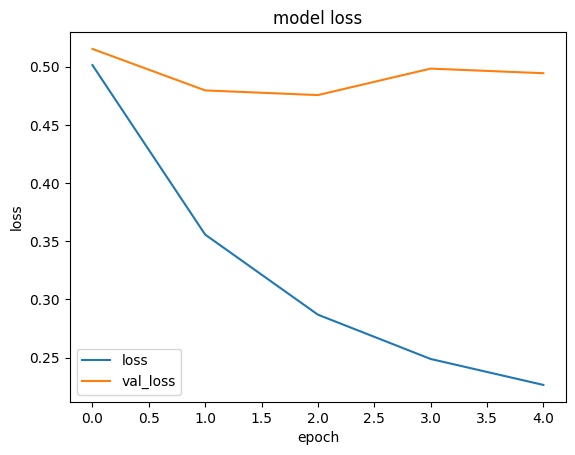

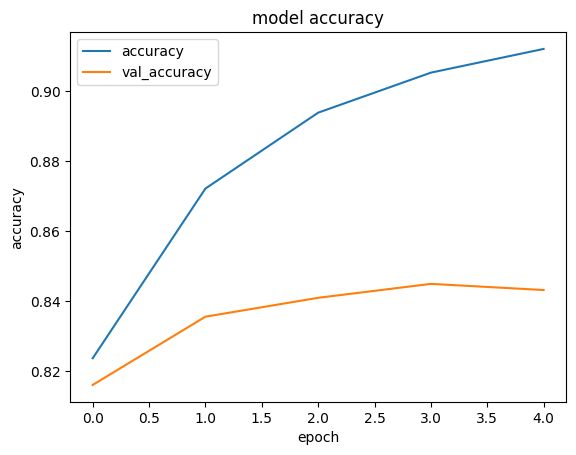

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

463/463 [==============================] - 37s 81ms/step


 Classification report : 

               precision    recall  f1-score   support

           0       0.82      0.85      0.83      3589
           1       0.80      0.89      0.84      4123
           2       0.89      0.84      0.86      4463
           3       0.89      0.77      0.82      2624

    accuracy                           0.84     14799
   macro avg       0.85      0.84      0.84     14799
weighted avg       0.85      0.84      0.84     14799



 Confusion Matrix : 

 [[3043  285  178   83]
 [ 230 3650  158   85]
 [ 262  349 3765   87]
 [ 190  269  145 2020]]


 Model Accuracy Score :    0.8431650787215352


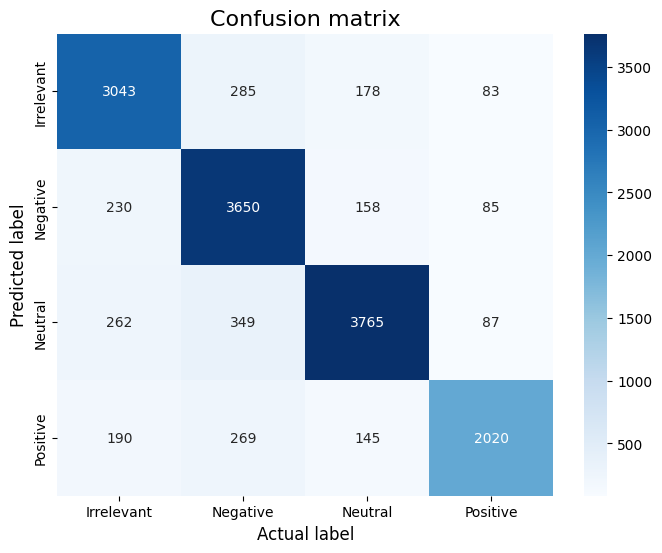

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns

y_pred = model.predict(x_val)
y_pred = np.argmax(y_pred, axis=1)
#test_la = np.argmax(np.array(y_val),axis=1)

cm = confusion_matrix(y_val, y_pred)

print("\n\n Classification report : \n\n",classification_report(y_val, y_pred))
print("\n\n Confusion Matrix : \n\n",cm)
print("\n\n Model Accuracy Score :   ",accuracy_score(y_val, y_pred))


plt.figure(figsize=(8,6))

cm = confusion_matrix(y_val, y_pred)
sentiment_classes = ['Irrelevant','Negative', 'Neutral', 'Positive']
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)
plt.show()


In [ ]:
!pip install pydot
!pip install graphviz

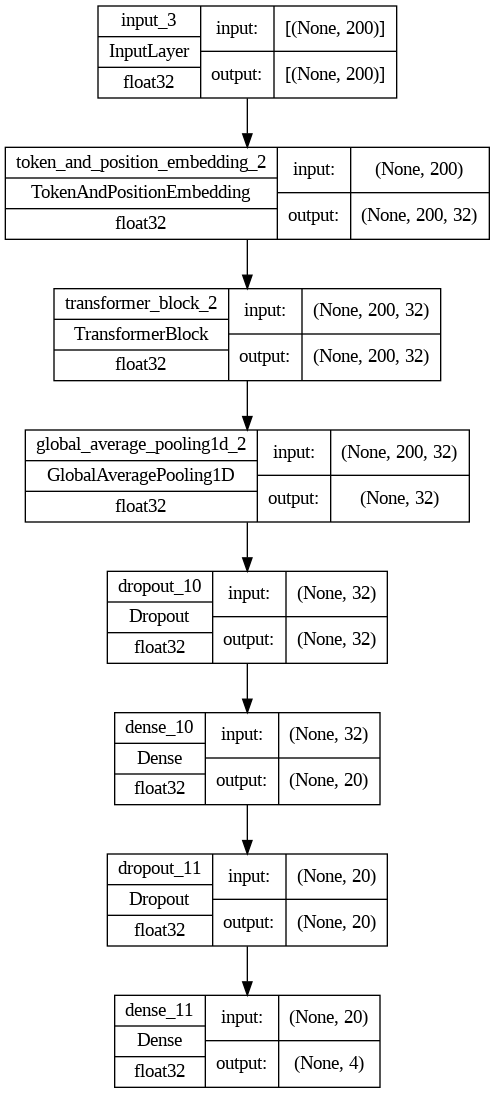

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)